In [1]:
import torch
from torchdiffeq import odeint_adjoint as odeint
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import time
import sys
sys.path.append('../')
from typing import Tuple, Any

%load_ext autoreload
%autoreload 2


import interflow as itf
import interflow.prior as prior
import interflow.fabrics
import interflow.stochastic_interpolant as stochastic_interpolant
from torch import autograd
from functorch import jacfwd, vmap


if torch.cuda.is_available():
    print('CUDA available, setting default tensor residence to GPU.')
    itf.util.set_torch_device('cuda')
else:
    print('No CUDA device found!')
print(itf.util.get_torch_device())


print("Torch version:", torch.__version__)

CUDA available, setting default tensor residence to GPU.
cuda
Torch version: 2.0.1+cu117


## Utility functions

In [2]:
def grab(var):
    """Take a tensor off the gpu and convert it to a numpy array on the CPU."""
    return var.detach().cpu().numpy()


def compute_likelihoods(
    s: torch.nn.Module,
    interpolant: stochastic_interpolant.Interpolant,
    n_save: int,
    n_step: int,
    eps: int,
    bs: int
) -> Tuple[torch.tensor, torch.tensor]:
    """Draw samples from the probability flow and SDE models, and compute likelihoods."""
    
    
    sde_flow = stochastic_interpolant.MirrorSDEIntegrator(
        s=s, eps=eps, interpolant=interpolant, n_save=n_save, n_likelihood=1, n_step=n_step
    )
    
    with torch.no_grad():
        x0_tests  = target(bs)
        xfs_sde   = sde_flow.rollout_forward(x0_tests) # [n_save x bs x dim]
        xf_sde    = grab(xfs_sde[-1].squeeze())        # [bs x dim]
        x0s_sdeflow, _ = sde_flow.rollout_likelihood(xfs_sde[-1])
    
    return xf_sde


def log_metrics(
    s: torch.nn.Module,
    interpolant: stochastic_interpolant.Interpolant,
    n_save: int,
    n_step: int,
    likelihood_bs: int, 
    s_loss: torch.tensor,
    s_grad: torch.tensor,
    eps: torch.tensor,
    data_dict: dict
) -> None:
    # log loss and gradient data
    s_loss   = grab(s_loss).mean(); data_dict['s_losses'].append(s_loss)
    s_grad   = grab(s_grad).mean(); data_dict['s_grads'].append(s_grad)


    
    
def make_plots(
    s: torch.nn.Module,
    interpolant: stochastic_interpolant.Interpolant,
    n_save: int,
    n_step: int, ## number of sde steps in [0,1]
    likelihood_bs: int,
    counter: int,
    metrics_freq: int,
    eps: torch.tensor,
    data_dict: dict
) -> None:
    """Make plots to visualize samples and evolution of the likelihood."""
    # compute likelihood and samples for SDE and probability flow.
    xf_sde = compute_likelihoods(
        s, interpolant, n_save, n_step, eps, likelihood_bs
    )


    ### plot the loss, test logp, and samples from interpolant flow
    fig, axes = plt.subplots(1,2, figsize=(12,4))
    print("EPOCH:", counter)
    print("LOSS, GRAD:", s_loss, s_grad)


    # plot loss over time.
    nsaves = len(data_dict['s_losses'])
    epochs = np.arange(nsaves)*metrics_freq
    axes[0].plot(epochs, data_dict['s_losses'], label = "s" )
    axes[0].set_title("LOSS")
    axes[0].legend()


    # plot samples from SDE.
    axes[1].scatter(
        xf_sde[:,0], xf_sde[:,1], vmin=0.0, vmax=0.05, alpha = 0.2)
    axes[1].set_xlim(-5,5)
    axes[1].set_ylim(-6.5,6.5)
    axes[1].set_title("Samples from SDE", fontsize=14)



    fig.suptitle(r"$\epsilon = $" + str(grab(eps)),  fontsize=16, y = 1.05)
    plt.show()
    
    


def train_step(
    bs: int,
    interpolant: stochastic_interpolant.Interpolant,
    opt_s  : Any,
    sched_s: Any,
    lower_upper: tuple = (0.0001, 0.9999)
):
    """
    Take a single step of optimization on the training set.
    """
    opt_s.zero_grad()
    lower, upper = lower_upper[0], lower_upper[1]

    # construct batch
    
    x0s = base(bs)
    x1s = target(bs)
    ts  = lower + (upper - lower)*torch.rand(size=(bs,))


    # compute the loss
    loss_start = time.perf_counter()
    loss_s     = loss_fn_s(s, x0s, x1s, ts, interpolant)
    loss_end   = time.perf_counter()


    # compute the gradient
    backprop_start = time.perf_counter()
    loss_s.backward()
    s_grad = torch.tensor([torch.nn.utils.clip_grad_norm_(s.parameters(), float('inf'))])
    backprop_end = time.perf_counter()


    # perform the update.
    update_start = time.perf_counter()
    opt_s.step()
    sched_s.step()
    update_end = time.perf_counter()


    if counter < 5:
        print(f'Timing [Loss: {loss_end - loss_start}], [Backprop: {backprop_end-backprop_start}], [Update: {update_end-update_start}].')


    return loss_s.detach(), s_grad.detach()

### Define target

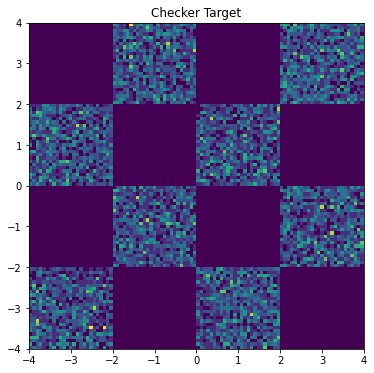

Batch Shape: (10000, 2)


In [3]:

ndim = 2
def target(bs):
    x1 = torch.rand(bs) * 4 - 2
    x2_ = torch.rand(bs) - torch.randint(2, (bs,)) * 2
    x2 = x2_ + (torch.floor(x1) % 2)
    return (torch.cat([x1[:, None], x2[:, None]], 1) * 2)


target_samples = grab(target(10000))


fig = plt.figure(figsize=(6,6))
plt.hist2d(target_samples[:,0], target_samples[:,1], bins = 100, range=[[-4,4],[-4,4]]);
plt.title("Checker Target")
plt.show()


print("Batch Shape:", target_samples.shape)
# target_logp_est = target.log_prob(target(10000)).mean()

### Define Base Distribution which functions as the intermediate noise

In [4]:
base_loc     = torch.zeros(ndim)
base_var     = torch.ones(ndim)
base         = prior.SimpleNormal(base_loc, 1.0*base_var)
base_samples = grab(base(20000))

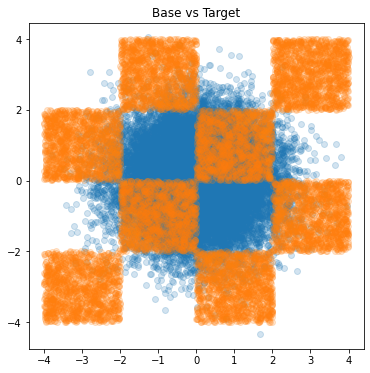

In [5]:
fig = plt.figure(figsize=(6,6,))
plt.scatter(base_samples[:,0], base_samples[:,1],  label = 'base', alpha = 0.2);
plt.scatter(target_samples[:,0], target_samples[:,1], alpha = 0.2);
plt.title("Bimodal Target")
plt.title("Base vs Target")
plt.show()

### Define Interpolant: A mirror interpolant, meaning that $x_0 \sim \rho_{\text{data}}$ $x_1 \sim N(0,1)$ and $x_t = x_0 + \gamma(t)x_1$

In [6]:
gamma_type = 'brownian'
path = 'mirror'
interpolant  = stochastic_interpolant.Interpolant(path=path, gamma_type=gamma_type)

### Define losses for b and s

In [7]:
loss_fn_s = stochastic_interpolant.make_loss(method='shared', 
                                             interpolant = interpolant, loss_type='mirror')


### Define velocity field and optimizers

In [8]:
base_lr      = 2e-3
hidden_sizes = [256, 256, 256, 256]
in_size      = (ndim+1)
out_size     = (ndim)
inner_act    = 'relu'
final_act    = 'none'
print_model  = False


s       = itf.fabrics.make_fc_net(hidden_sizes=hidden_sizes, in_size=in_size, out_size=out_size, inner_act=inner_act, final_act=final_act)
opt_s   = torch.optim.Adam(s.parameters(), lr=base_lr)
sched_s = torch.optim.lr_scheduler.StepLR(optimizer=opt_s, step_size=1500, gamma=0.4)


eps          = torch.tensor(0.5)
N_era        = 14
N_epoch      = 500
plot_bs      = 5000  # number of samples to use when plotting
bs           = 2000    # number of samples from rho_0 in batch
metrics_freq = 50    # how often to log metrics, e.g. if logp is not super cheap don't do it everytime
plot_freq    = 500   # how often to plot
n_save       = 10    # how often to checkpoint SDE integrator
loss_fac     = 4.0   # ratio of learning rates for w to v
n_step       = 100   # number of steps taken by the SDE in [0,1]


if print_model:
    print("Here's the model s:", s)

Timing [Loss: 0.4295279259677045], [Backprop: 0.002505571988876909], [Update: 0.0016028709942474961].
EPOCH: 1
LOSS, GRAD: tensor(0.0115) tensor([0.5521])


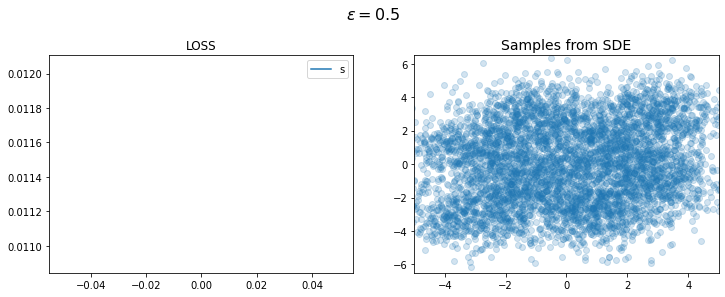

Timing [Loss: 0.0010933020384982228], [Backprop: 0.0010624160058796406], [Update: 0.0005714529543183744].
Timing [Loss: 0.001004379999358207], [Backprop: 0.000998689967673272], [Update: 0.0005305649829097092].
Timing [Loss: 0.0009997860179282725], [Backprop: 0.0010121370432898402], [Update: 0.0005079259863123298].
EPOCH: 501
LOSS, GRAD: tensor(-1.3002) tensor([3.7083])


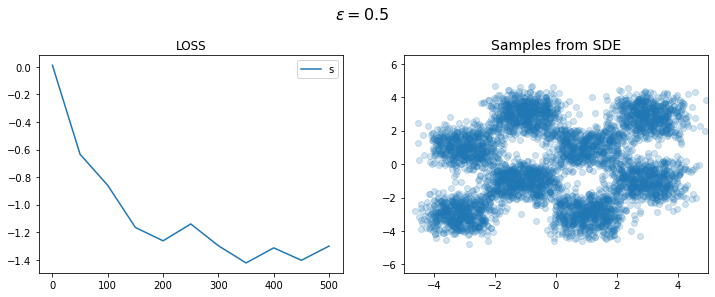

EPOCH: 1001
LOSS, GRAD: tensor(-1.6645) tensor([1.9900])


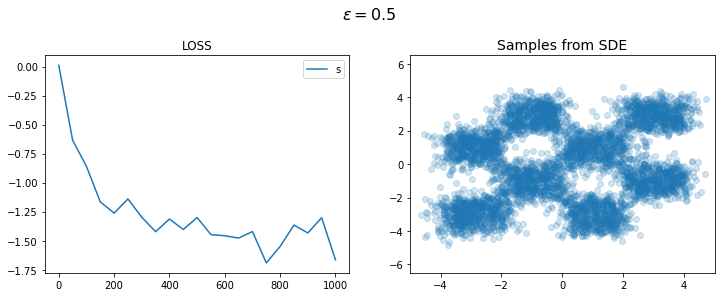

EPOCH: 1501
LOSS, GRAD: tensor(-1.3028) tensor([4.0255])


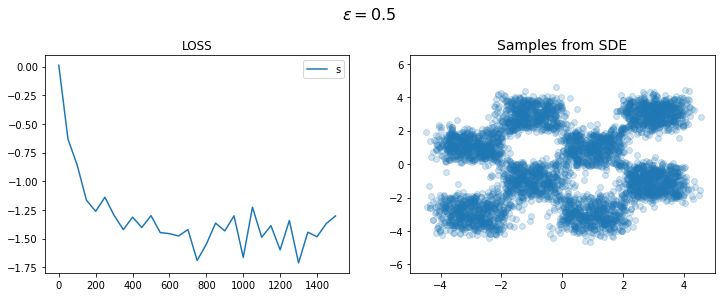

EPOCH: 2001
LOSS, GRAD: tensor(-1.2644) tensor([3.0432])


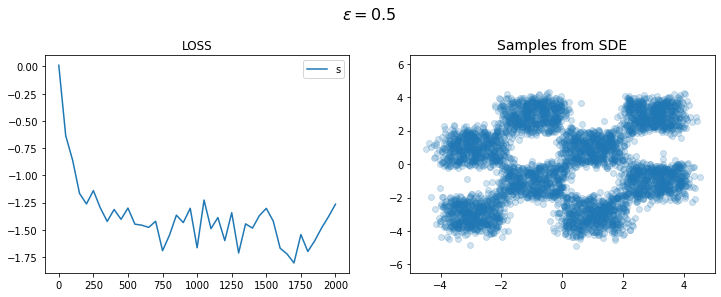

EPOCH: 2501
LOSS, GRAD: tensor(-1.0690) tensor([5.0616])


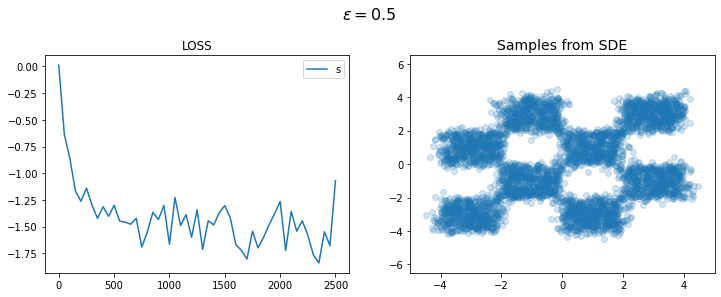

EPOCH: 3001
LOSS, GRAD: tensor(-1.4637) tensor([2.7339])


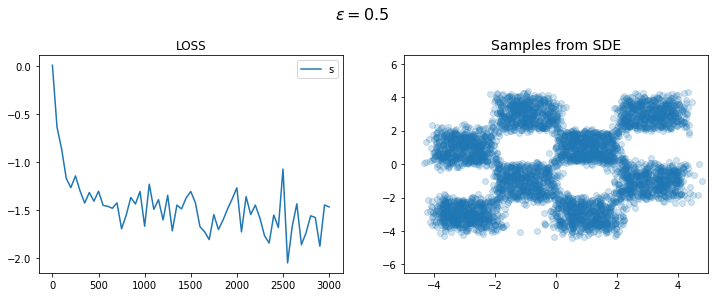

EPOCH: 3501
LOSS, GRAD: tensor(-2.0481) tensor([4.6071])


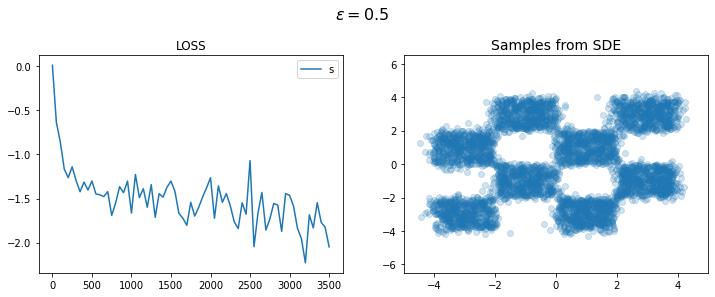

EPOCH: 4001
LOSS, GRAD: tensor(-1.8657) tensor([3.0311])


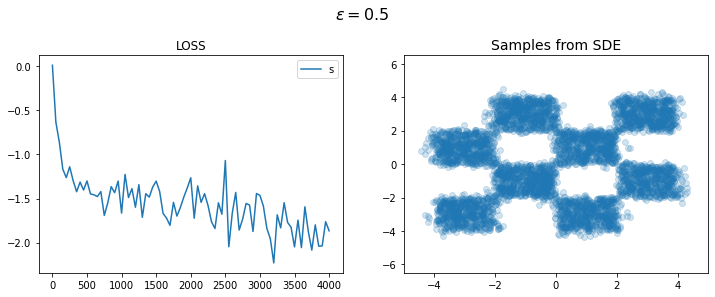

EPOCH: 4501
LOSS, GRAD: tensor(-1.9021) tensor([8.6957])


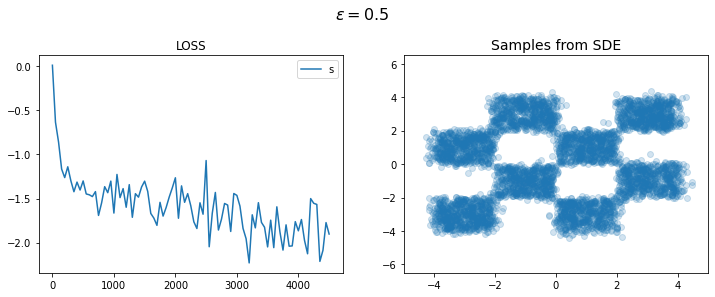

EPOCH: 5001
LOSS, GRAD: tensor(-2.1608) tensor([3.1716])


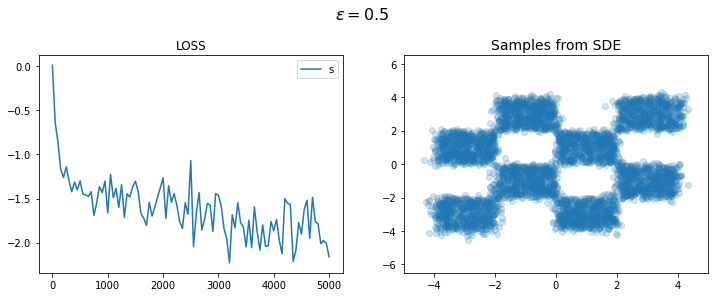

EPOCH: 5501
LOSS, GRAD: tensor(-2.0899) tensor([4.8739])


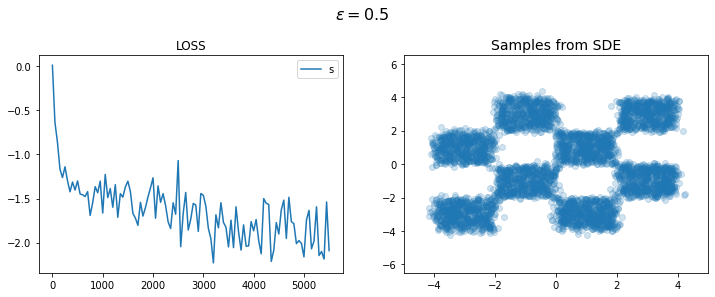

EPOCH: 6001
LOSS, GRAD: tensor(-1.8911) tensor([4.4081])


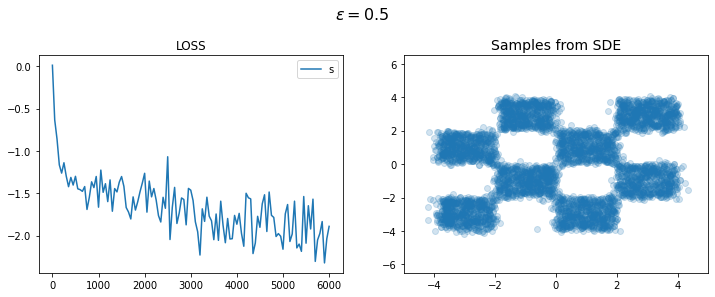

EPOCH: 6501
LOSS, GRAD: tensor(-1.7455) tensor([3.8865])


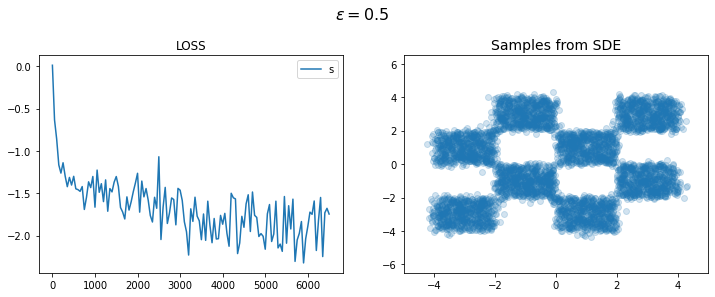

In [9]:
data_dict = {
    's_losses': [],
    's_grads': [],
    'times': [],
}

counter = 1
for i, era in enumerate(range(N_era)):
    for j, epoch in enumerate(range(N_epoch)):
        s_loss, s_grad = train_step(bs, interpolant, opt_s, sched_s,
        )


        if (counter - 1) % metrics_freq == 0:
            log_metrics(s, interpolant, n_save, n_step, bs, 
                        s_loss, s_grad, eps, data_dict)


        if (counter - 1) % plot_freq == 0:
            make_plots(s, interpolant, n_save, n_step, plot_bs, counter, metrics_freq, eps, data_dict)


        counter+=1

In [10]:
n_step = 600
bs = 40000
n_save = n_step // 4
eps = torch.tensor(6.0)
lower = 0.0001
upper = 0.9999
sde_flow = stochastic_interpolant.MirrorSDEIntegrator(
    s=s, 
    start_end=(lower, upper),
    n_step=n_step,
    eps=eps, 
    interpolant=interpolant,
    n_save=n_save, 
    n_likelihood=1
)



with torch.no_grad():
    # x0_tests  = target(bs)
    x0_tests  = torch.ones(size=(bs, 2))
    xfs_sde   = sde_flow.rollout_forward(x0_tests) # [n_save x bs x dim]
    xf_sde    = grab(xfs_sde[-1].squeeze())        # [bs x dim]

xf_true = grab(target(40000))

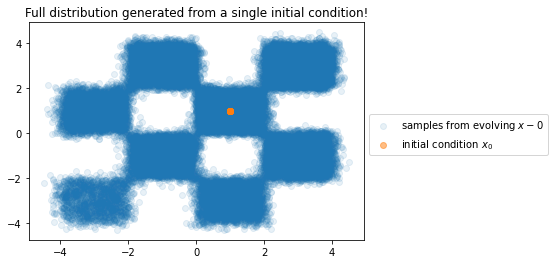

In [11]:
init_sde = grab(x0_tests)
plt.scatter(xf_sde[:,0], xf_sde[:,1], alpha = 0.1, label=r'samples from evolving $x-0$')
plt.scatter(init_sde[:,0], init_sde[:,1], alpha=0.5, label=r'initial condition $x_0$')
plt.title("Full distribution generated from a single initial condition!")
plt.legend(loc = 'upper left', bbox_to_anchor=(1.0, 0.6))